In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy.stats import norm
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
prob_list = np.linspace(.01,.99,22)

In [7]:
data = pd.read_excel('C:/Users/michelj8/Documents/Github/data_sets/farm_gdp.xls', sheet_name = 'data')
data = data.query('observation_date < 2020 & observation_date > 1959')
data = data.dropna().reset_index()
column_name = data.columns[-1]
data.head()

,index,observation_date,B359RC1Q027SBEA
0,49,1959-04-01,16.939
1,50,1959-07-01,16.715
2,51,1959-10-01,17.561
3,52,1960-01-01,17.014
4,53,1960-04-01,17.973


<ipython-input-9-3d0daeaa7b11>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts['log'] = np.log(ts['level'])


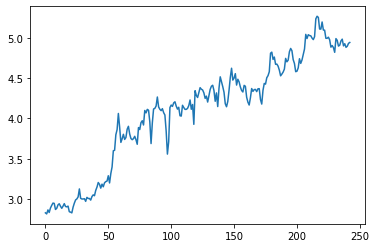

In [9]:
ts = data[[column_name]]
ts.columns = ['level']
ts['log'] = np.log(ts['level'])
ts['log'].plot()

In [10]:
ts['log_dif'] = ts['log'].diff(1)
ts['lag_log_dif'] = ts['log_dif'].shift(1)
ts['4_ldif'] = ts['log'].diff(4)
ts = ts.dropna()
ts

,level,log,log_dif,lag_log_dif,4_ldif
4,17.973,2.888871,0.054834,-0.031644,0.059252
5,18.578,2.921978,0.033107,0.054834,0.105672
6,19.118,2.950630,0.028652,0.033107,0.084950
7,19.048,2.946962,-0.003668,0.028652,0.112926
8,17.658,2.871189,-0.075773,-0.003668,-0.017682
...,...,...,...,...,...
238,137.947,4.926870,0.026622,-0.083298,0.018799
239,131.887,4.881945,-0.044924,0.026622,-0.079668
240,133.749,4.895965,0.014019,-0.044924,-0.087580
241,138.616,4.931708,0.035743,0.014019,0.031460


# 1 step ahead qunatile estimation

In [11]:
quant_df = pd.DataFrame(columns = ['quant','int','slope']).set_index(['quant'])
quantiles = np.linspace(.01,.99,31)

for quantile in quantiles:
    mod = smf.quantreg('log_dif~ lag_log_dif', ts )

    res = mod.fit(q=quantile)
    quant_df.loc[quantile,'int'] = res.params[0]
    quant_df.loc[quantile,'slope'] = res.params[1]

quant_df

C:\Users\michelj8\Anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:235: RuntimeWarning: invalid value encountered in less_equal
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)


,int,slope
quant,,
0.010000,-0.227959,0.298608
0.042667,-0.14136,0.16485
0.075333,-0.124041,0.155086
0.108000,-0.0907416,0.0227137
0.140667,-0.0689107,0.0229272
0.173333,-0.0607468,0.0033595
0.206000,-0.0537872,0.0131693
0.238667,-0.0434906,0.00490459
0.271333,-0.0342548,0.0218811


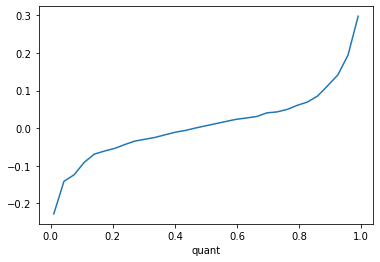

In [14]:
quant_df['int'].plot()

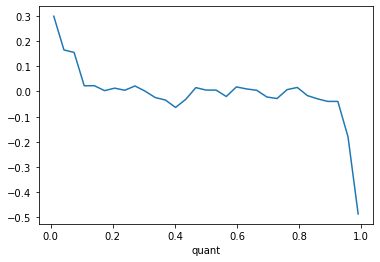

In [15]:
quant_df['slope'].plot()

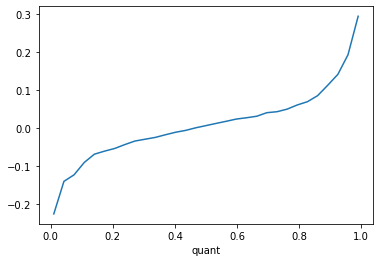

In [16]:
ts_median = ts['log_dif'].median()
quant_df.apply(lambda s: s[0] + s[1]*ts_median, axis = 1).plot()

In [17]:
def k_ahead_dist(value, k_step):
    dist = []
    for _ in range(0,100):
        sim = 0.0
        state = value
        
        for k in range(0, k_step):
            rand_quant = np.random.choice(quantiles)
            const, slope = quant_df.loc[rand_quant]
            
            state = const + slope*state
            sim = sim+ state
        dist.append(sim)
    return dist

# Direct quantile estimation

In [23]:
ts['year_lag'] = ts['4_ldif'].shift(4)
direct_quant_df = pd.DataFrame(columns = ['quant','int','slope']).set_index(['quant'])

reg_df = ts[['4_ldif']]
reg_df[['year_lag']] = reg_df[['4_ldif']].shift(4)
reg_df = reg_df.dropna()
reg_df.columns = ['x','y']

direct_quantiles = [.5*(1-x) for x in prob_list] + [.5*(1+x) for x in prob_list]

for quantile in direct_quantiles:
    mod = smf.quantreg('y~x', reg_df )

    res = mod.fit(q=quantile)
    direct_quant_df.loc[quantile,'int'] = res.params[0]
    direct_quant_df.loc[quantile,'slope'] = res.params[1]

direct_quant_df = direct_quant_df.sort_index()
direct_quant_df

C:\Users\michelj8\Anaconda3\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
C:\Users\michelj8\Anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:235: RuntimeWarning: invalid value encountered in less_equal
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)


,int,slope
quant,,
0.005000,-0.348928,-0.362647
0.028333,-0.208963,-0.382128
0.051667,-0.188574,-0.357787
0.075000,-0.170947,-0.381023
0.098333,-0.149277,-0.340408
0.121667,-0.135418,-0.362215
0.145000,-0.115688,-0.297452
0.168333,-0.0962988,-0.346597
0.191667,-0.0715223,-0.41145


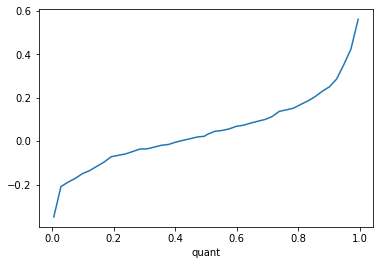

In [24]:
direct_quant_df['int'].plot()

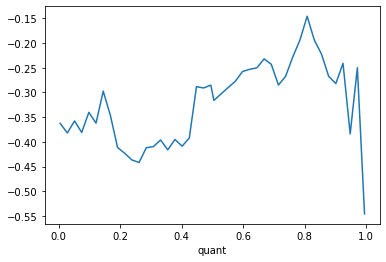

In [25]:
direct_quant_df['slope'].plot()

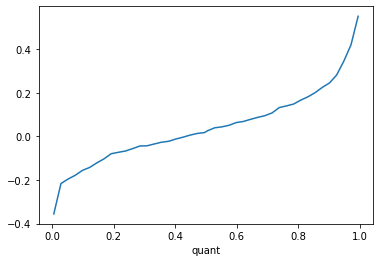

In [26]:
ts_median = ts['year_lag'].median()
direct_quant_df.apply(lambda s: s[0] + s[1]*ts_median, axis = 1).plot()

# Coverage comparisons

In [27]:
coverage_df = pd.DataFrame(columns = ['prob','indirect_ar_pct', 'direct_pct']).set_index('prob')

for prob in prob_list:
    coverage_df.loc[prob] = 0.0

for time in range(ts.index.min() + 4, ts.index.max() +1):
    y_t4 = ts.loc[time,'log']
    y_t = ts.loc[time-4,'log']
    x_t = ts.loc[time-4, 'log_dif']
    
    direct_xt = ts.loc[time-4,'4_ldif']
    
    indirect_sims = k_ahead_dist(x_t,4)
    
    for prob in prob_list:
        indirect_ci = y_t + np.quantile(indirect_sims, [ .5*(1-prob) ,.5*(1+prob)])
        
        lower_direct = direct_quant_df.loc[.5*(1-prob)].values
        lower = lower_direct[0] + lower_direct[1]*direct_xt
        upper_direct = direct_quant_df.loc[.5*(1+prob)].values
        upper = upper_direct[0] + upper_direct[1]*direct_xt

        direct_ci = y_t + np.array( [lower,upper]   )
        
        coverage_df.loc[prob] = coverage_df.loc[prob] + [1*(y_t4 > indirect_ci[0])*(y_t4<indirect_ci[1]),
                                                        1*(y_t4 > direct_ci[0])*(y_t4<direct_ci[1])]

coverage_df = coverage_df.div(len(ts))
coverage_df['theoretical'] = prob_list

In [28]:
coverage_df

,indirect_ar_pct,direct_pct,theoretical
prob,,,
0.010000,0.008368,0.033473,0.010000
0.056667,0.058577,0.096234,0.056667
0.103333,0.133891,0.142259,0.103333
0.150000,0.188285,0.200837,0.150000
0.196667,0.230126,0.271967,0.196667
0.243333,0.292887,0.317992,0.243333
0.290000,0.347280,0.359833,0.290000
0.336667,0.389121,0.397490,0.336667
0.383333,0.439331,0.422594,0.383333


Text(0.5, 1.0, 'Scaled empirical Coverage Curve')

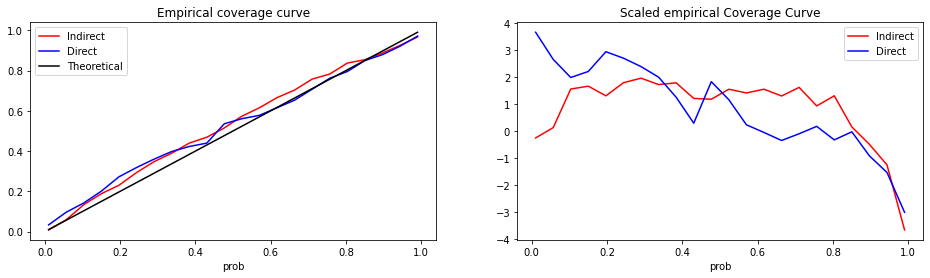

In [29]:
prob_list = coverage_df.index.values

fig, [axa,axb] = plt.subplots(1,2, figsize = (16,4))
coverage_df.plot(ax = axa, color =  ['red','blue','black'] )
axa.legend(['Indirect', 'Direct', 'Theoretical'])
axa.set_title('Empirical coverage curve')

coverage_df[['indirect_ar_pct','direct_pct']].subtract(prob_list, axis = 0).div(np.sqrt(prob_list*(1-prob_list)), axis = 0).multiply(np.sqrt(len(ts))).plot(ax = axb,color = ['red','blue'] )
axb.legend(['Indirect', 'Direct'])
axb.set_title('Scaled empirical Coverage Curve')

# Score functions

In [30]:
def score(x,lower,upper,prob):
    return (upper-lower) + (2/(1-prob))*(max(x-upper,0) + max(lower-x,0))

In [31]:
score_df = pd.DataFrame(columns = ['prob','indirect', 'direct']).set_index('prob')

for prob in prob_list:
    score_df.loc[prob] = 0.0

for time in range(ts.index.min() + 4, ts.index.max() +1):
    y_t4 = ts.loc[time,'log']
    y_t = ts.loc[time-4,'log']
    x_t = ts.loc[time-4, 'log_dif']
    
    direct_xt = ts.loc[time-4,'4_ldif']
    
    indirect_sims = k_ahead_dist(x_t,4)
    
    for prob in prob_list:
        indirect_ci = y_t + np.quantile(indirect_sims, [ .5*(1-prob) ,.5*(1+prob)])
        
        lower_direct = direct_quant_df.loc[.5*(1-prob)].values
        lower = lower_direct[0] + lower_direct[1]*direct_xt
        upper_direct = direct_quant_df.loc[.5*(1+prob)].values
        upper = upper_direct[0] + upper_direct[1]*direct_xt

        direct_ci = y_t + np.array( [lower,upper]   )

        
        score_df.loc[prob] = score_df.loc[prob] + [score(y_t4, indirect_ci[0], indirect_ci[1], prob),
                                                   score(y_t4, direct_ci[0], direct_ci[1], prob) ]        
score_df = score_df.div(len(ts))

Text(0.5, 1.0, 'Interval forecast scores')

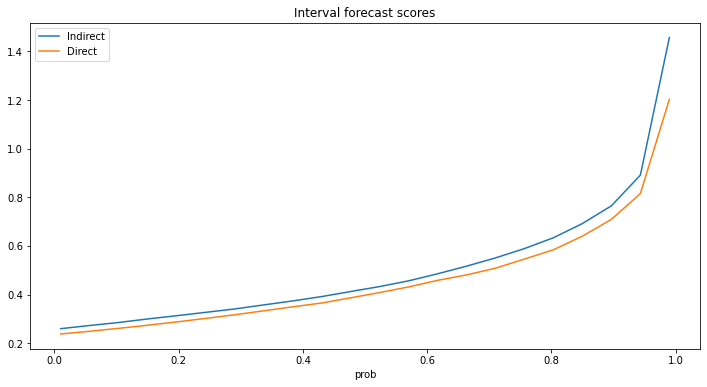

In [32]:
fig, ax = plt.subplots(figsize = (12,6))
score_df.plot(ax = ax)

ax.legend(['Indirect','Direct'])
ax.set_title('Interval forecast scores')

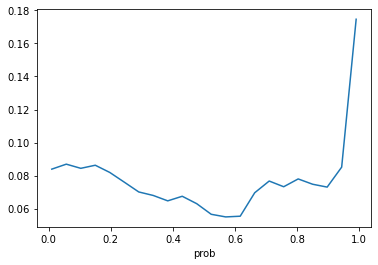

In [33]:
( (score_df['indirect']-score_df['direct'])/score_df['indirect'] ).plot()